In [1]:
%cd /home/hess/projects/discriminator-guidance/
%load_ext autoreload
%autoreload 1

/home/hess/projects/discriminator-guidance


In [2]:
import numpy as np

import time
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from IPython.display import Image, display
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import torch.utils.data as data_utils
import polars as pol
from tqdm import tqdm
import xarray as xr
import xskillscore as xs
import pandas as pd
import pickle 
from matplotlib.animation import FuncAnimation
import wandb
import sys

import src.xarray_utils as xu
from src.edm.data import DataModule
from src.edm.diffusion_model import DiffusionModel
from src.edm.inference import DiffusionInference
from src.edm.diffusion_stochastic_sampler import KarrasStochasticSampler
from src.config import read_yaml

from diffusion_training import main

In [7]:
config = read_yaml("/home/hess/projects/discriminator-guidance/configs/diffusion_cond_daily_config.yaml")
config["trainer"]["max_epochs"] = 150
config["plot_validation_samples"] = True
config["dataset"]["train_start"] = 1979 
config

{'rng_seed': 123,
 'float32_matmul_precision': 'high',
 'dataset': {'dataset_path': '/p/tmp/hess/scratch/discriminator-guidance/datasets/era5_tp_1940_2022_daily_1deg.nc',
  'train_start': 1979,
  'train_end': 2000,
  'valid_start': 2001,
  'valid_end': 2010,
  'test_start': 2011,
  'test_end': 2020,
  'transforms': ['log', 'normalize_minus1_to_plus1'],
  'lazy': False,
  'epsilon': 1e-05,
  'apply_padding': False,
  'crop_lat_target': True,
  'conditional': True,
  'target_variable': 'precipitation'},
 'data_loader': {'batch_size': 2,
  'num_workers': 8,
  'pin_memory': True,
  'persistent_workers': True,
  'drop_last': True},
 'model': 'diffusion',
 'plot_validation_samples': True,
 'diffusion': {'sigma_data': 0.5,
  'sigma_max': 80.0,
  'sigma_min': 0.002,
  'loss_weights': 'uniform'},
 'diffusion_network': {'in_channels': 2,
  'out_channels': 1,
  'model_channels': 128,
  'channel_mult': [1, 2, 2],
  'channel_mult_emb': 3,
  'num_blocks': 3,
  'attn_resolutions': []},
 'scheduler': 

In [ ]:
main(config)

[rank: 0] Seed set to 123
/home/hess/.conda/envs/climsim/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# create training data

In [4]:
fname = "/p/tmp/hess/scratch/turbulence-simulation/experiment_2/2d_turbulence_step_*"
ds = xr.open_mfdataset(fname)
ds

<xarray.Dataset> Size: 189GB
Dimensions:    (time: 361000, lat: 256, lon: 256)
Coordinates:
  * lon        (lon) int64 2kB 1 2 3 4 5 6 7 8 ... 250 251 252 253 254 255 256
  * lat        (lat) int64 2kB 1 2 3 4 5 6 7 8 ... 250 251 252 253 254 255 256
  * time       (time) int64 3MB 0 1 2 3 4 ... 360995 360996 360997 360998 360999
Data variables:
    vorticity  (time, lat, lon) float64 189GB dask.array<chunksize=(1000, 256, 256), meta=np.ndarray>

In [51]:
ds_sub = ds.isel(time=slice(0, None, 2)).isel(time=slice(5000,95_000)).rename({"lat": "latitude", "lon": "longitude"})
#ds_sub = ds.isel(time=slice(0, None, 4)).isel(time=slice(500,None)).rename({"lat": "latitude", "lon": "longitude"})
#ds_sub = ds.vorticity[5_000:95_000].rename({"lat": "latitude", "lon": "longitude"})
start_date = "2000-01-01"
num_days = len(ds_sub.time)  # Number of days you want
new_time = pd.date_range(start=start_date, periods=num_days, freq="D")
ds_sub = ds_sub.assign_coords(time=new_time)


In [14]:
ds_sub

<xarray.DataArray 'time' (time: 90000)> Size: 720kB
array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', ..., '2246-05-28T00:00:00.000000000',
       '2246-05-29T00:00:00.000000000', '2246-05-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 720kB 2000-01-01 2000-01-02 ... 2246-05-30

In [11]:
ds_sub.isel(time=slice(0,40_000))
ds_sub.isel(time=slice(40_000, 60_000))

<xarray.Dataset> Size: 10GB
Dimensions:    (time: 20000, latitude: 256, longitude: 256)
Coordinates:
  * longitude  (longitude) int64 2kB 1 2 3 4 5 6 7 ... 251 252 253 254 255 256
  * latitude   (latitude) int64 2kB 1 2 3 4 5 6 7 ... 251 252 253 254 255 256
  * time       (time) datetime64[ns] 160kB 2109-07-08 2109-07-09 ... 2164-04-09
Data variables:
    vorticity  (time, latitude, longitude) float64 10GB dask.array<chunksize=(250, 256, 256), meta=np.ndarray>

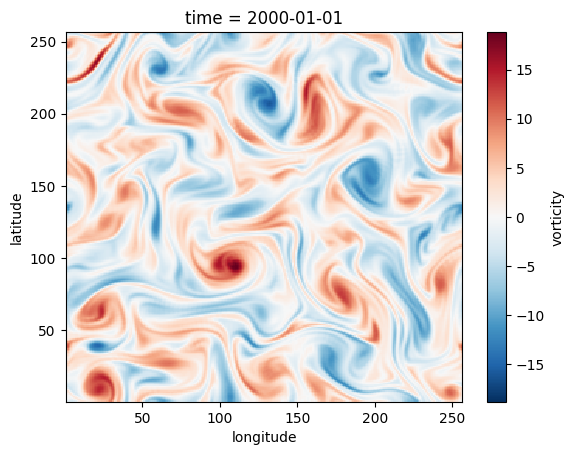

In [52]:
ds_sub.vorticity[0].plot()

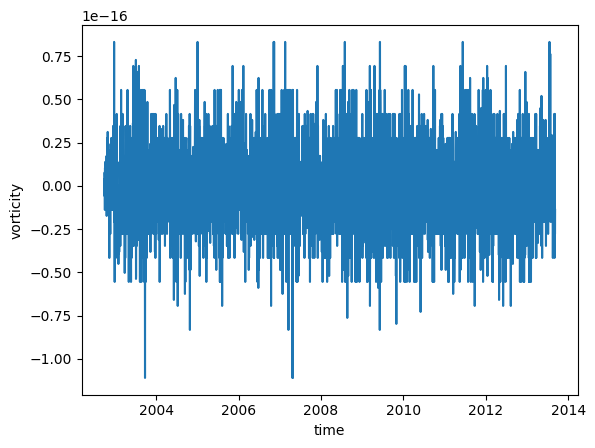

In [36]:
ds_sub[1000:5000].mean(dim=("latitude", "longitude")).plot()

In [58]:
df = xr.open_dataset("/p/tmp/hess/scratch/discriminator-guidance/datasets/vorticity_2000_2246.nc")
df

<xarray.Dataset> Size: 47GB
Dimensions:    (longitude: 256, latitude: 256, time: 90000)
Coordinates:
  * longitude  (longitude) int64 2kB 1 2 3 4 5 6 7 ... 251 252 253 254 255 256
  * latitude   (latitude) int64 2kB 1 2 3 4 5 6 7 ... 251 252 253 254 255 256
  * time       (time) datetime64[ns] 720kB 2000-01-01 2000-01-02 ... 2246-05-30
Data variables:
    vorticity  (time, latitude, longitude) float64 47GB ...

In [54]:
#xu.write_dataset(ds=ds_sub, file_name="/p/tmp/hess/scratch/discriminator-guidance/datasets/vorticity_sub_4_2000_2245.nc")
xu.write_dataset(ds=ds_sub, file_name="/p/tmp/hess/scratch/discriminator-guidance/datasets/vorticity_sub_2_2000_2246.nc")

writing to /p/tmp/hess/scratch/discriminator-guidance/datasets/vorticity_sub_2_2000_2246.nc
[########################################] | 100% Completed | 26.52 s


In [86]:
coarsened_ds = ds.coarsen(time=4, boundary="trim").mean()
new_ds = coarsened_ds.isel(time=slice(500,None)).rename({"lat": "latitude", "lon": "longitude"})
start_date = "2000-01-01"
num_days = len(new_ds.time)  # Number of days you want
new_time = pd.date_range(start=start_date, periods=num_days, freq="D")
new_ds = new_ds.assign_coords(time=new_time)

In [88]:
xu.write_dataset(ds=new_ds, file_name="/p/tmp/hess/scratch/discriminator-guidance/datasets/vorticity_sub_4_12k_2000_2031.nc")

writing to /p/tmp/hess/scratch/discriminator-guidance/datasets/vorticity_sub_4_12k_2000_2031.nc
[########################################] | 100% Completed | 6.26 sms


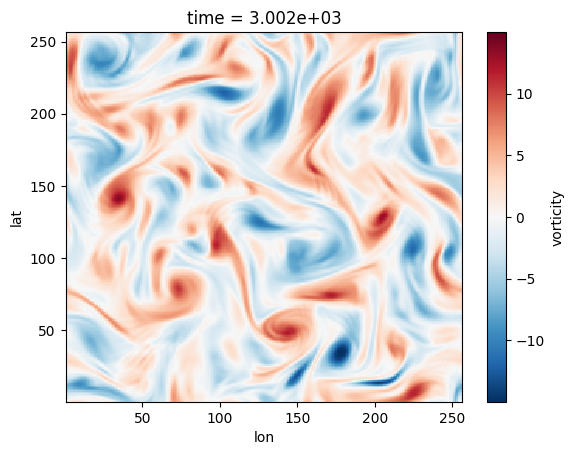

In [64]:
coarsened_ds.vorticity[500].plot()

0.48008965957176364


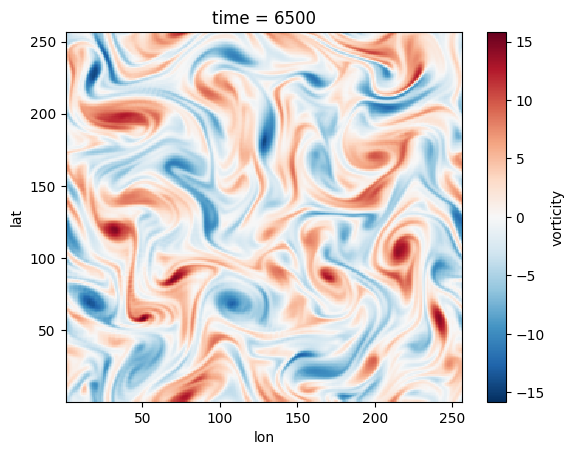

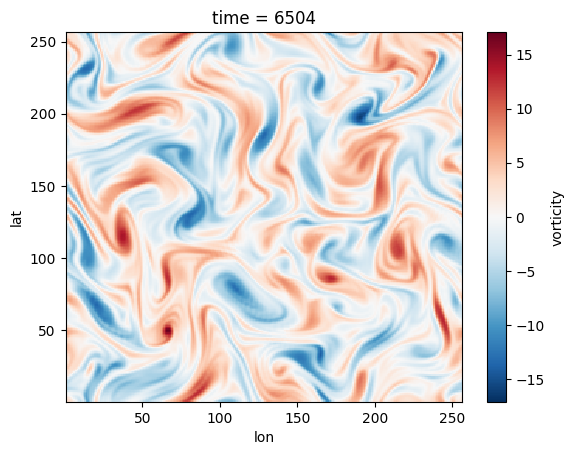

In [26]:
from xskillscore import pearson_r, pearson_r_p_value
i = 5500
j = 5504

print(pearson_r(ds.vorticity[i], ds.vorticity[j]).values)

ds.vorticity[i].plot()
plt.show()

ds.vorticity[j].plot()
plt.show()


In [40]:

ds.vorticity[5000].min().values

array(-15.27914711)

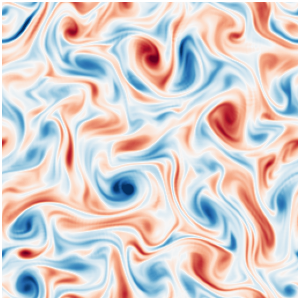

In [55]:
fig, ax = plt.subplots(1,1,figsize=(6, 6), constrained_layout=True)
def update(i):
    cmap='RdBu'
    
    #dt = 4
    #offset = 5000
    #index = np.arange(0+offset,20*dt+offset,dt)
    ax.imshow(ds_sub.vorticity[i],vmin=-15, vmax=15, origin='lower', cmap=cmap)
    ax.set_axis_off()
    
update(1)

output_filename = '/p/tmp/hess/scratch/discriminator-guidance/results/dg_2dturb_2.gif'
anim = FuncAnimation(fig, update, frames=np.arange(0, 20), interval=250, repeat=False)
anim.save(output_filename, dpi=50)
plt.close()

display(Image(filename=output_filename))